<a href="https://colab.research.google.com/github/ananynda/ananynda/blob/main/Plant_Seedlings_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
from glob import glob
from matplotlib import pyplot as plt

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding, import updated
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# %%
from IPython import get_ipython
from IPython.display import display
# %%
train_path = "/content/temp_train"
!mkdir temp_train
# %%
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')
# %%
# Update train_path to the location of train.zip in your Google Drive
train_path = "/content/drive/MyDrive/Data/plant-seedlings-classification.zip" # replace with correct path
# %%
# Create a temporary directory if it doesn't exist
!mkdir temp_train
# %%
# Extract the zip file to the temporary directory
from zipfile import ZipFile # Import ZipFile for extraction
with ZipFile(train_path, 'r') as zip:
  zip.extractall('./temp_train')
# %%
# Assuming all images are in subfolders within 'temp_train'
# Get a list of all image file paths
files = glob('/content/temp_train/plant-seedlings-classification/train/*/*.png') # Update path according to your structure
                                                                          # Assuming images are in subfolders within 'train'

trainImg = []                                              # Initialize empty list to store the image data as numbers.
trainLabel = []                                            # Initialize empty list to store the labels of images
j = 1
num = len(files)

# Obtain images and resizing, obtain labels
for img in files:
    '''
    Append the image data to trainImg list.
    Append the labels to trainLabel list.
    '''
    print(str(j) + "/" + str(num), end="\r")
    trainImg.append(cv2.resize(cv2.imread(img), (128, 128)))  # Get image (with resizing to 128x128)
    trainLabel.append(img.split('/')[-2])  # Get image label (folder name contains the class to which the image belong)
    j += 1

trainImg = np.asarray(trainImg)  # Train images set
trainLabel = pd.DataFrame(trainLabel)  # Train labels set

Mounted at /content/drive
mkdir: cannot create directory ‘temp_train’: File exists


In [2]:
#We have 4750 colored images that are 128 x 128 pixels
print(trainImg.shape)
print(trainLabel.shape)

(4750, 128, 128, 3)
(4750, 1)


In [3]:
#It seems that there are unequal amounts of each class
#This may negatively affect our model
#Namely, it will likely classify loose silky-bent and common chickweed better than all other classes
trainLabel[0].value_counts()

,count
0,
Loose Silky-bent,654
Common Chickweed,611
Scentless Mayweed,516
Small-flowered Cranesbill,496
Fat Hen,475
Charlock,390
Sugar beet,385
Cleavers,287
Black-grass,263


Sugar beet


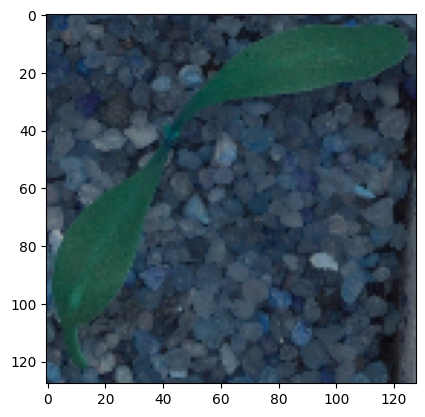

Black-grass


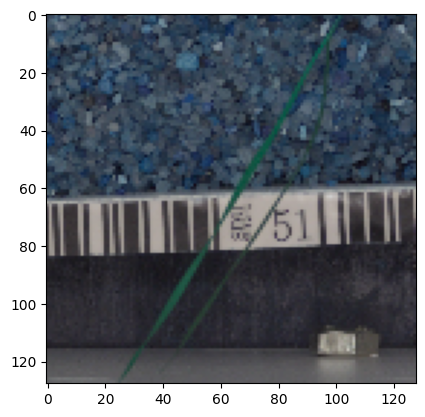

Scentless Mayweed


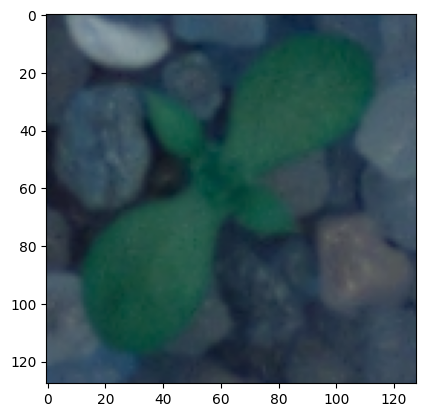

Charlock


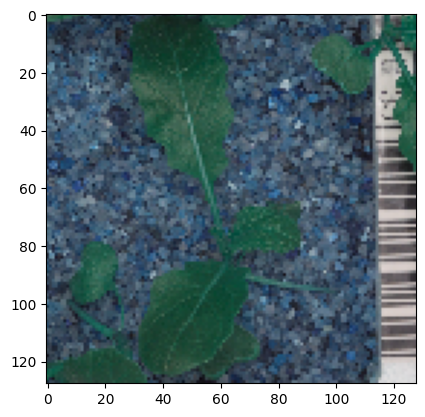

Loose Silky-bent


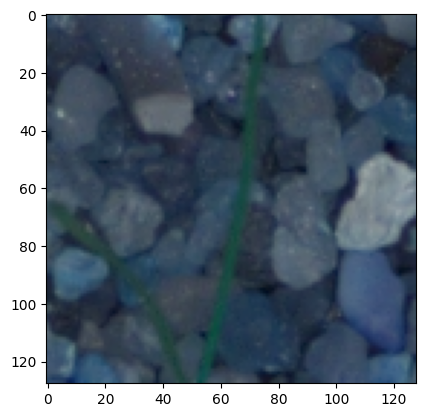

Cleavers


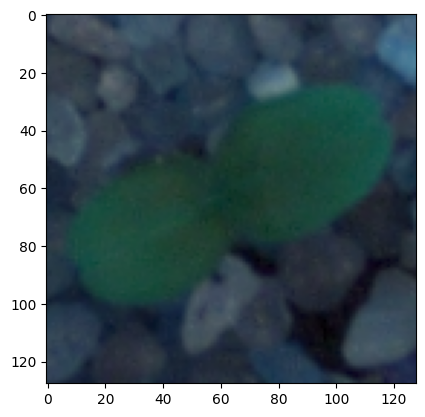

Common Chickweed


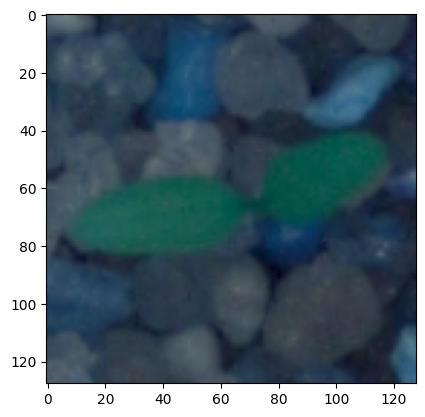

Common Chickweed


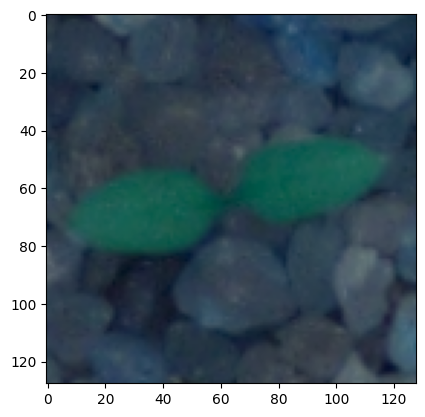

Small-flowered Cranesbill


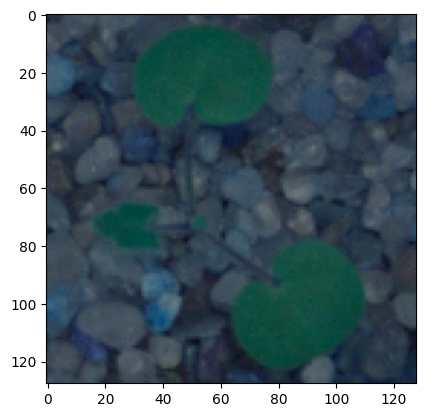

Fat Hen


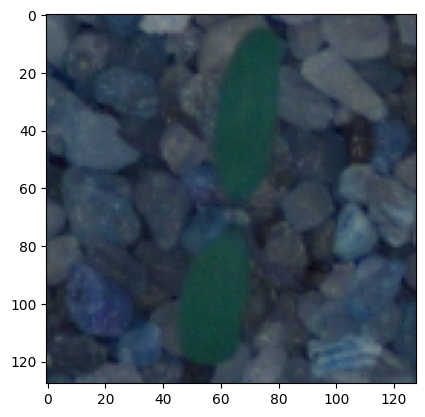

In [4]:
#Here is a very small sample of the different types of plant images I am working with
i = 0
for i in np.arange(4750, step =475):
    print(trainLabel[0][i])
    plt.imshow(trainImg[i])
    plt.show()

In [5]:
#Since the pixel values range from 0 to 255 for the RGB channels, I divide the x_train data by 255
trainImg = trainImg.astype('float32')
trainImg /= 255.0
#Making a copy of X_test for visualization at the very end
X = trainImg
y = trainLabel
X_train9, X_test9, y_train9, y_test9 = train_test_split(X, y, test_size=0.3, random_state=1)

Sugar beet


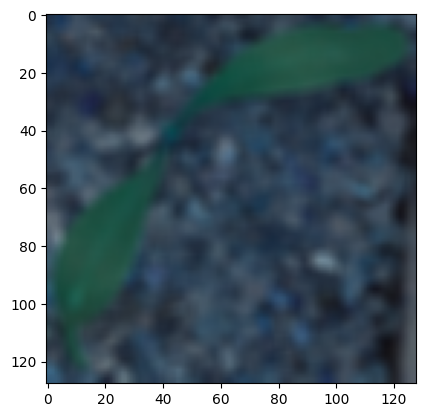

Black-grass


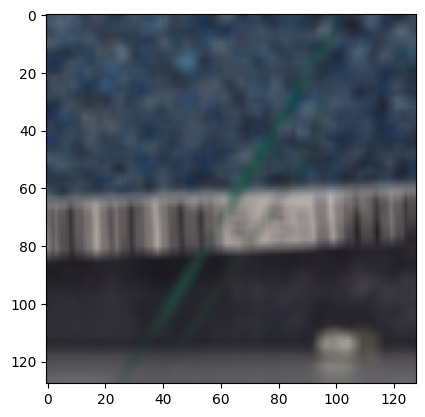

Scentless Mayweed


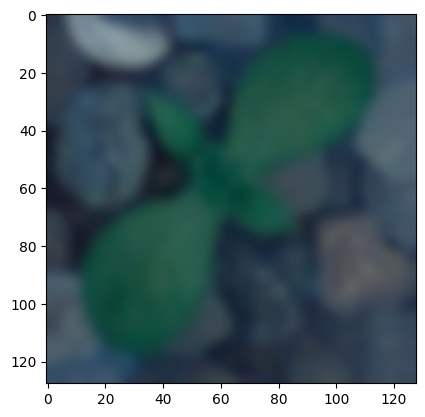

Charlock


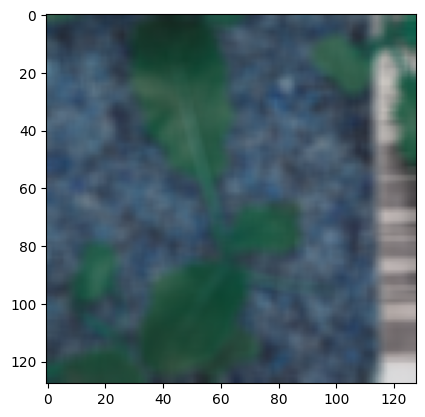

Loose Silky-bent


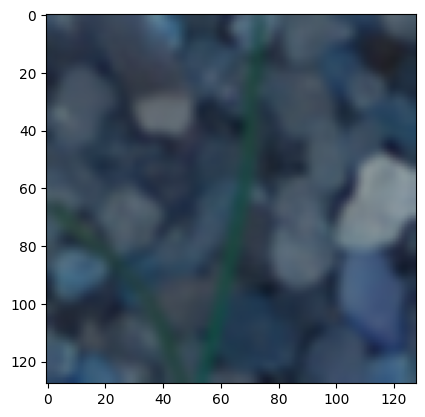

Cleavers


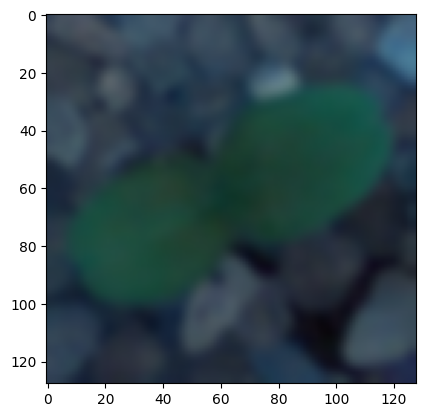

Common Chickweed


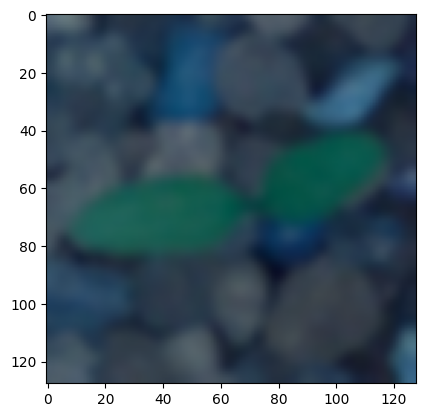

Common Chickweed


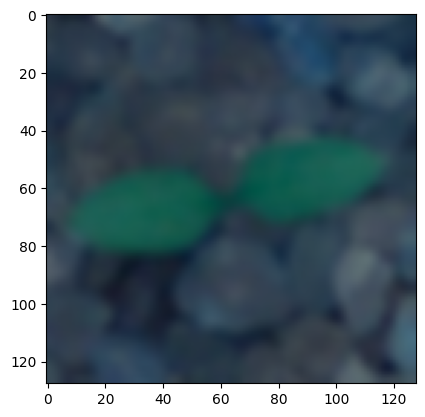

Small-flowered Cranesbill


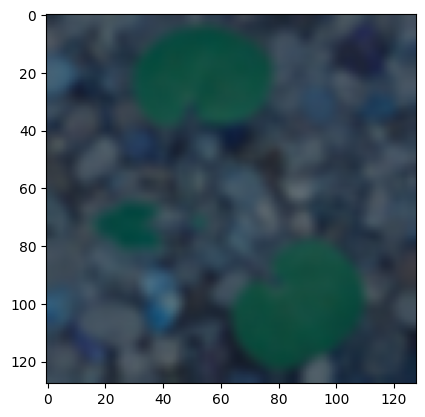

Fat Hen


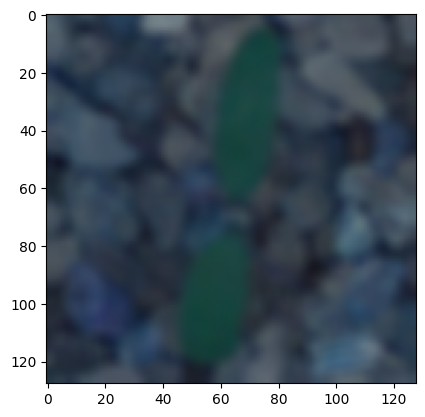

In [6]:
#I convolve the Gaussian kernel with the images
#I am using a 5x5 kernel
#Here is an example of the first observation of the image data being blurred
for i in range(len(trainImg)):
    trainImg[i] = cv2.GaussianBlur(trainImg[i],(5,5),cv2.BORDER_DEFAULT)
for i in np.arange(4750, step =475):
    print(trainLabel[0][i])
    plt.imshow(trainImg[i])
    plt.show()

**Making the Data Compatible**

In [7]:
trainImg

array([[[[0.12696704, 0.19080587, 0.27314985],
         [0.12440625, 0.19630916, 0.28354746],
         [0.11905298, 0.20475242, 0.30208677],
         ...,
         [0.2800111 , 0.3635122 , 0.43990925],
         [0.2883752 , 0.36892837, 0.44699058],
         [0.28826886, 0.36751354, 0.44676   ]],

        [[0.12725468, 0.19149683, 0.27668062],
         [0.12490818, 0.19634315, 0.28607118],
         [0.11970394, 0.20450865, 0.3038601 ],
         ...,
         [0.27391866, 0.35615015, 0.43160465],
         [0.28569448, 0.36653933, 0.44415244],
         [0.28832415, 0.3685123 , 0.4481107 ]],

        [[0.12880614, 0.19605123, 0.2842127 ],
         [0.13029878, 0.20154916, 0.29255575],
         [0.12566267, 0.21078004, 0.3108994 ],
         ...,
         [0.25929245, 0.33990213, 0.413416  ],
         [0.27468276, 0.35757947, 0.43243945],
         [0.27886304, 0.3629654 , 0.43968946]],

        ...,

        [[0.22528204, 0.3742562 , 0.4918585 ],
         [0.21977547, 0.37209466, 0.49017474]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)
y_test1 = y_test

In [9]:
X_train.shape


(3325, 128, 128, 3)

In [10]:
#Reshape data into shapes compatible with Keras models (will do if needed)
X_train = X_train.reshape(X_train.shape[0], 128, 128, 3)
X_val = X_val.reshape(X_val.shape[0], 128, 128, 3)
X_test = X_test.reshape(X_test.shape[0], 128, 128, 3)

In [11]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)
y_test2 = y_test
y_val = pd.get_dummies(y_val)

In [12]:
#The label for the first y_train observation is 'Small-flowered Cranesbill'
y_train.iloc[0]

,3702
0_Black-grass,False
0_Charlock,False
0_Cleavers,False
0_Common Chickweed,False
0_Common wheat,False
0_Fat Hen,False
0_Loose Silky-bent,False
0_Maize,False
0_Scentless Mayweed,False
0_Shepherds Purse,False


In [13]:
y_train


,0_Black-grass,0_Charlock,0_Cleavers,0_Common Chickweed,0_Common wheat,0_Fat Hen,0_Loose Silky-bent,0_Maize,0_Scentless Mayweed,0_Shepherds Purse,0_Small-flowered Cranesbill,0_Sugar beet
3702,False,False,False,False,False,False,False,False,False,False,True,False
4252,False,False,False,False,False,False,False,True,False,False,False,False
945,False,False,False,False,False,False,False,False,True,False,False,False
3610,False,False,False,False,False,False,False,False,False,False,True,False
4046,False,False,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2895,False,False,False,True,False,False,False,False,False,False,False,False
2763,False,False,False,True,False,False,False,False,False,False,False,False
905,False,False,False,False,False,False,False,False,True,False,False,False
3980,False,False,False,False,False,False,False,False,False,True,False,False


In [14]:
X_train.shape


(3325, 128, 128, 3)

**Building the CNN Model**

In [15]:
batch_size = None

model = models.Sequential()
model.add(layers.Conv2D(128, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(100, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(75, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(50, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(50, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 100)         │         320,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 100)         │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 100)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 75)          │          67,575 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 75)          │             300 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 75)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 75)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 50)          │          33,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 50)          │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 50)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 50)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 12)                  │             6

 Total params: 435,777 (1.66 MB)

 Trainable params: 435,071 (1.66 MB)

 Non-trainable params: 706 (2.76 KB)

In [16]:
#initiate Adam optimizer
adam = optimizers.Adam(learning_rate=0.01)
# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
#This is the first model that I tried running
#It took a tremendously long time and did not have a good accuracy, so I terminated it midway
history = model.fit(X_train,
                    y_train,
                    batch_size=50,
                    epochs=100,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1)

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1239s 18s/step - accuracy: 0.0992 - loss: 4.3643 - val_accuracy: 0.1809 - val_loss: 2.4171
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1201s 17s/step - accuracy: 0.1533 - loss: 2.4239 - val_accuracy: 0.1388 - val_loss: 2.4028
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1191s 18s/step - accuracy: 0.1401 - loss: 2.4146 - val_accuracy: 0.1388 - val_loss: 2.3977
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1194s 17s/step - accuracy: 0.1485 - loss: 2.4117 - val_accuracy: 0.1388 - val_loss: 2.4005
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1182s 18s/step - accuracy: 0.1322 - loss: 2.4292 - val_accuracy: 0.1388 - val_loss: 2.4020
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1222s 18s/step - accuracy: 0.1440 - loss: 2.4068 - val_accuracy: 0.1388 - val_loss: 2.4022
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1221s 18s/step - accuracy: 0.1416 - loss: 2.4118 - val_accuracy: 0.1388 - val_loss: 2.4021
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 1182s 18s/step - accuracy: 0.1359 - loss: 2.4162 - 

In [ ]:
#Now, I try modifying the previous model in hopes of attaining a better accuracy


In [ ]:
model = models.Sequential()
# I instantiate a sequential model that follows the pattern: Conv2D, MaxPooling, Batchnormalization, dropout several times
model.add(layers.Conv2D(128, (5, 5), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(80, (3, 3), padding='same', activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(80, (3, 3), padding='same', activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
#Adding a GlobalMaxPooling and Flatten layer before adding dense layers
#I add dropout consistently to avoid overfitting
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(50, activation="relu"))
model.add(layers.BatchNormalization())
#Using softmax to get probabilities of being a certain class (there are 12 options and thus 12 nodes)
model.add(layers.Dense(12, activation="softmax"))

model.summary()

In [ ]:
#initiate Adam optimizer
adam = optimizers.Adam(learning_rate=0.01)
#Compiling the model using categorical crossentropy as a loss function
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# I will train for 30 epochs with a batch size of 50 using the training and validation set
history = model.fit(X_train,
                    y_train,
                    batch_size=50,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1)

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test)
print('Test loss:', results[0])
print('Test accuracy:', results[1])

In [ ]:
predictions = model.predict(X_test)
preds = []
for i in range(len(predictions)):
     preds.append(np.argmax(predictions[i]))

In [ ]:
class_map = {
0:"Black-grass",
1:"Charlock",
2:"Cleavers",
3:"Common Chickweed",
4:"Common wheat",
5:"Fat Hen",
6:"Loose Silky-bent",
7:"Maize",
8:"Scentless Mayweed",
9:"Shepherds Purse",
10:"Small-flowered Cranesbill",
11:"Sugar beet",
}
y_pred = list(map(class_map.get, preds))

In [ ]:
y_pred


In [ ]:
y_true


In [ ]:
from sklearn.metrics import confusion_matrix
y_true = list(y_test1[0])
labels = ["Black-grass","Charlock", "Cleavers","Common Chickweed","Common wheat", "Fat Hen",
"Loose Silky-bent","Maize","Scentless Mayweed","Shepherds Purse","Small-flowered Cranesbill","Sugar beet" ]
confmat = confusion_matrix(y_true, y_pred, labels = labels)

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confmat,
                              display_labels=labels)
disp.plot(xticks_rotation = 'vertical')

**Visualizing Predictions**

In [ ]:
plt.imshow(X_test9[2])
y_pred[2]

In [ ]:
plt.imshow(X_test9[3])
y_pred[3]

In [ ]:
plt.imshow(X_test9[33])
y_pred[33]

In [ ]:
plt.imshow(X_test9[36])
y_pred[36]

In [ ]:
plt.imshow(X_test9[59])
y_pred[59]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))